In [ ]:
import numpy as np
import pandas as pd
import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
final_2018_2021 = pd.read_csv('/content/drive/MyDrive/bethelegend/final_2018_2021.csv', encoding='euc-kr')

In [ ]:
#선발 출장에 한정
final_2018_2021 = final_2018_2021[final_2018_2021['start_member'] == 1]

In [ ]:
#3월, 4월 데이터 제외
final_2018_2021 = final_2018_2021.loc[final_2018_2021['day']>= 500]

In [ ]:
#0타수 데이터 제외
final_2018_2021 = final_2018_2021[final_2018_2021['ab']>0]

### **RNN in Be the legend**

In [ ]:
rnn_data = final_2018_2021.loc[:, ['name', 'day', 'start_member', 'vs_team', 'avg', 'slg', 'ops', 'avLI', 'RE24', 'WPA', 'home/away_avg_y', 'vs_ab', 'vs_hit', 'vs_avg', 'recent_5days_avg', 'recent_5games_avg', 'recent_10games_avg', 'success_10days', 'success_10games', 'result_y']]

In [ ]:
len(rnn_data)

29395

In [ ]:
len(rnn_data[rnn_data['result_y'] == 1]) / len(rnn_data) * 100

67.47065827521688

In [ ]:
import numpy as np
from sklearn.preprocessing import minmax_scale
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier

### **Training data set / Test data set 분할**

In [ ]:
def train_test_set(data):
  rnn_train, rnn_test = train_test_split(rnn_data, test_size=0.15, random_state=50)

  X_train = rnn_train.loc[:, ['avg', 'slg', 'ops', 'avLI', 'RE24', 'WPA', 'home/away_avg_y', 'vs_avg', 'recent_5days_avg', 'recent_5games_avg', 'recent_10games_avg', 'success_10days', 'success_10games']]
  y_train = rnn_train.loc[:, ['result_y']]

  X_test = rnn_test.loc[:, ['avg', 'slg', 'ops', 'avLI', 'RE24', 'WPA', 'home/away_avg_y', 'vs_avg', 'recent_5days_avg', 'recent_5games_avg', 'recent_10games_avg', 'success_10days', 'success_10games']]
  y_test = rnn_test.loc[:, ['result_y']]

  X_train = X_train.to_numpy()
  y_train = y_train.to_numpy()
  X_test = X_test.to_numpy()
  y_test = y_test.to_numpy()

  X_train = minmax_scale(X_train, feature_range=(0,1), axis = 0)
  X_test = minmax_scale(X_test, feature_range=(0,1), axis = 0)

  number_of_train_samples = X_train.shape[0]
  width = X_train.shape[1]
  X_train = X_train.reshape(number_of_train_samples, 1, width)

  number_of_test_samples = X_test.shape[0]
  X_test = X_test.reshape(number_of_test_samples, 1, width)

  return X_train, y_train, X_test, y_test

### **Stratified K-Fold Cross Validation (auto)**

In [ ]:
rnn_data = final_2018_2021.loc[:, ['name', 'day', 'start_member', 'vs_team', 'avg', 'slg', 'ops', 'avLI', 'RE24', 'WPA', 'home/away_avg_y', 'vs_ab', 'vs_hit', 'vs_avg', 'recent_5days_avg', 'recent_5games_avg', 'recent_10games_avg', 'success_10days', 'success_10games', 'result_y']]

In [ ]:
X = rnn_data.loc[:, ['avg', 'slg', 'ops', 'avLI', 'RE24', 'WPA', 'home/away_avg_y', 'vs_avg', 'recent_5days_avg', 'recent_5games_avg', 'recent_10games_avg', 'success_10days', 'success_10games']]
y = rnn_data.loc[:, ['result_y']]

In [ ]:
X = X.to_numpy()
y = y.to_numpy()

In [ ]:
X = minmax_scale(X, feature_range=(0,1), axis = 0)

In [ ]:
number_of_samples = X.shape[0]
width = X.shape[1]
X = X.reshape(number_of_samples, 1, width)

In [ ]:
X.shape, y.shape

((29395, 1, 13), (29395, 1))

In [ ]:
def gru_k():
    model = Sequential()
    model.add(GRU(50, input_shape = (1,13), return_sequences = True))
    model.add(GRU(50, return_sequences = True))
    model.add(GRU(13, return_sequences = True))
    model.add(GRU(13, return_sequences = True))
    model.add(GRU(1, return_sequences = False, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['acc'])
    
    return model

In [ ]:
model = KerasClassifier(build_fn=gru_k, epochs=150, batch_size=32, verbose=0)  

In [ ]:
 kfold = KFold(n_splits = 5, shuffle = True, random_state = 50) 
 results = cross_val_score(model, X, y, cv=kfold)

In [ ]:
results, round(np.mean(results),3)

(array([0.81714576, 0.81323355, 0.80898112, 0.81459433, 0.8031978 ]), 0.811)

### **Validation data set / Training data set 분할**

In [ ]:
X_val = X_train[:5000]
X_train = X_train[5000:]

y_val = y_train[:5000]
y_train = y_train[5000:]

### **Loss & Acc graph**



In [ ]:
def loss_acc_graph(history_dict):
  # history_dict = history.history

  loss = history_dict['loss']
  val_loss = history_dict['val_loss']
  acc = history_dict['acc']
  val_acc = history_dict['val_acc']

  epochs = range(1, len(loss)+1)

  plt.figure(figsize=(12,5))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, 'red', label='Training loss') 
  plt.plot(epochs, val_loss, 'green', label='Validation loss')
  plt.title('Training & Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, acc, 'red', label='Training acc') 
  plt.plot(epochs, val_acc, 'green', label='Validation acc')
  plt.title('Training & Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

### **SimpleRNN**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation, LSTM
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier

**model_2**

In [ ]:
X_train, y_train, X_test, y_test = train_test_set(rnn_data)

In [ ]:
def simple_rnn2():
    model = Sequential()
    model.add(SimpleRNN(32, input_shape = (1,13)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['acc'])
    
    return model

In [ ]:
model2 = simple_rnn2()
history2 = model2.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test), verbose = 0)
history_dict2 = history2.history

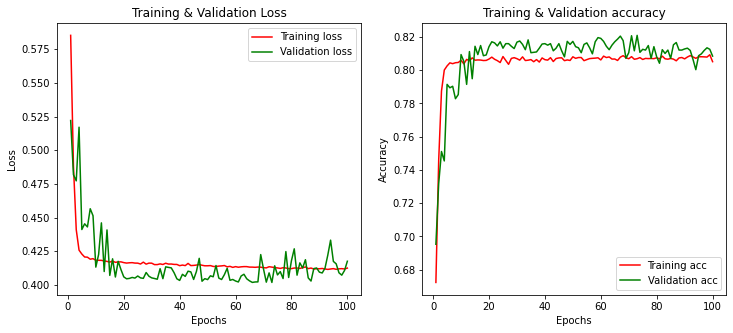

In [ ]:
loss_acc_graph(history_dict2)

In [ ]:
results = model2.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

138/138 [==============================] - 0s 1ms/step - loss: 0.4176 - acc: 0.8084
Test accuracy:  0.8083900213241577


**model_3**

In [ ]:
X_train, y_train, X_test, y_test = train_test_set(rnn_data)

In [ ]:
def simple_rnn3():
    model = Sequential()
    model.add(SimpleRNN(32, input_shape = (1,13), return_sequences = False))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['acc'])
    
    return model

In [ ]:
model3 = simple_rnn3()
history3 = model3.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test), verbose = 0)
history_dict3 = history3.history

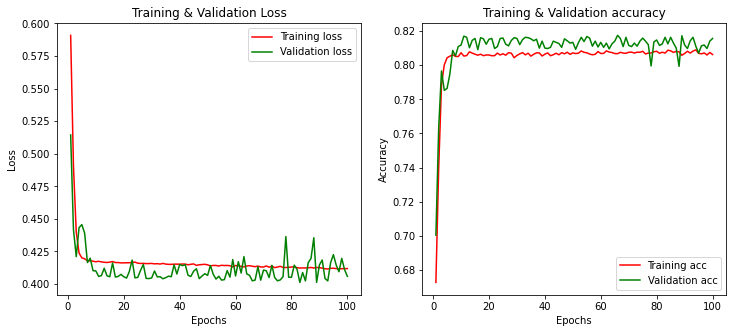

In [ ]:
loss_acc_graph(history_dict3)

In [ ]:
results = model3.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

138/138 [==============================] - 0s 1ms/step - loss: 0.4059 - acc: 0.8156
Test accuracy:  0.815646231174469


**model_4**

In [ ]:
X_train, y_train, X_test, y_test = train_test_set(rnn_data)

In [ ]:
X_train.shape, X_test.shape

((24985, 1, 13), (4410, 1, 13))

In [ ]:
def simple_rnn4():
    model = Sequential()
    model.add(SimpleRNN(50, input_shape = (1,13), return_sequences = True))
    model.add(SimpleRNN(32, return_sequences = False))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['acc'])
    
    return model

In [ ]:
model4 = simple_rnn4()
history4 = model4.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test), verbose = 0)
history_dict4 = history4.history

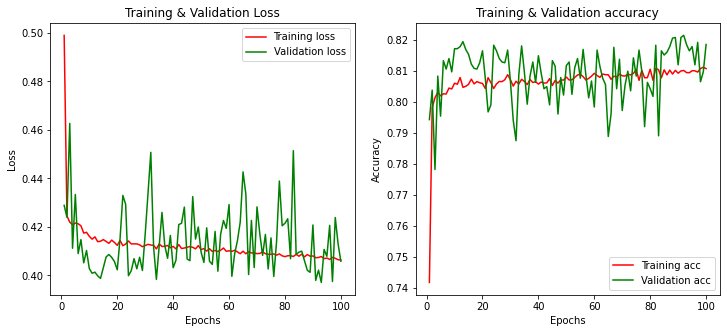

In [ ]:
loss_acc_graph(history_dict4)

In [ ]:
results = model4.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

138/138 [==============================] - 0s 1ms/step - loss: 0.4058 - acc: 0.8186
Test accuracy:  0.8185940980911255


**model_5**

In [ ]:
X_train, y_train, X_test, y_test = train_test_set(rnn_data)

In [ ]:
def simple_rnn5():
    model = Sequential()
    model.add(SimpleRNN(50, input_shape = (1,13), return_sequences = True, activation='relu'))
    model.add(SimpleRNN(32, return_sequences = False, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['acc'])
    
    return model

In [ ]:
model5 = simple_rnn5()
history5 = model5.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test), verbose = 0)
history_dict5 = history5.history

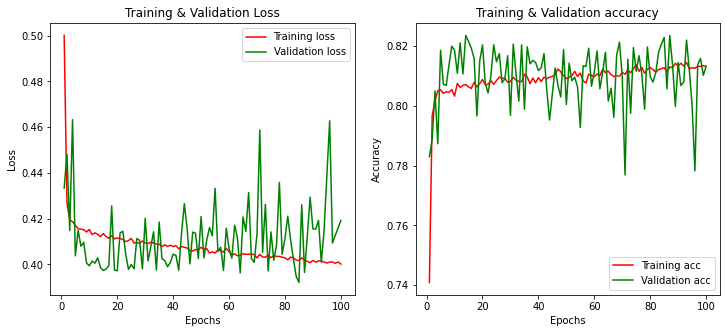

In [ ]:
loss_acc_graph(history_dict5)

In [ ]:
results = model5.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

138/138 [==============================] - 0s 1ms/step - loss: 0.4192 - acc: 0.8132
Test accuracy:  0.8131519556045532


**model_6**

In [ ]:
X_train, y_train, X_test, y_test = train_test_set(rnn_data)

In [ ]:
def simple_rnn6():
    model = Sequential()
    model.add(SimpleRNN(50, input_shape = (1,13), return_sequences = True, activation='tanh'))
    model.add(SimpleRNN(32, return_sequences = False, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['acc'])
    
    return model

In [ ]:
model6 = simple_rnn6()
history6 = model6.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test), verbose = 0)
history_dict6 = history6.history

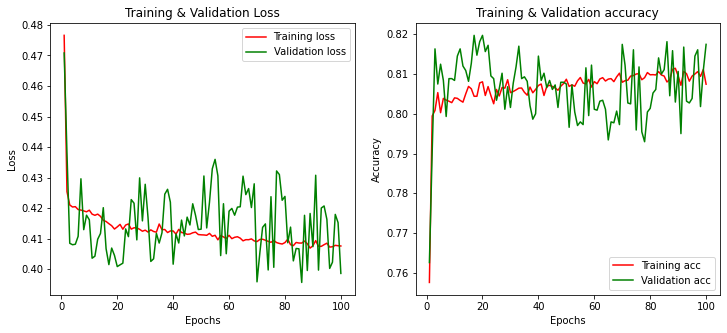

In [ ]:
loss_acc_graph(history_dict6)

In [ ]:
results = model6.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

138/138 [==============================] - 0s 1ms/step - loss: 0.3986 - acc: 0.8175
Test accuracy:  0.817460298538208


**model_7**

In [ ]:
X_train, y_train, X_test, y_test = train_test_set(rnn_data)

In [ ]:
def simple_rnn7():
    model = Sequential()
    model.add(SimpleRNN(50, input_shape = (1,13), return_sequences = True, activation='sigmoid'))
    model.add(SimpleRNN(32, return_sequences = False, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['acc'])
    
    return model

In [ ]:
model7 = simple_rnn7()
history7 = model7.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test), verbose = 0)
history_dict7 = history7.history

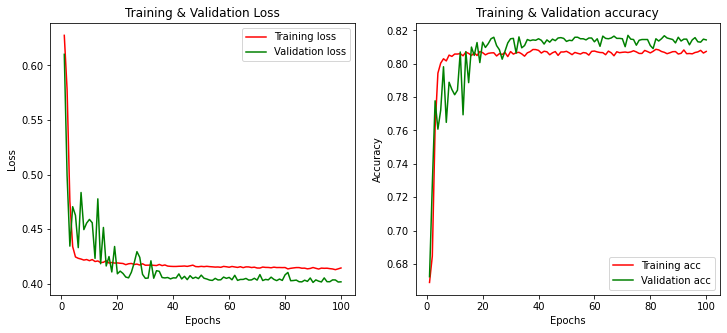

In [ ]:
loss_acc_graph(history_dict7)

In [ ]:
results = model7.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

138/138 [==============================] - 0s 1ms/step - loss: 0.4017 - acc: 0.8143
Test accuracy:  0.8142856955528259


**model_8**

In [ ]:
X_train, y_train, X_test, y_test = train_test_set(rnn_data)

In [ ]:
def simple_rnn8():
    model = Sequential()
    model.add(SimpleRNN(48, input_shape = (1,13), return_sequences = True, activation='tanh'))
    model.add(SimpleRNN(10, return_sequences = False, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['acc'])
    
    return model

In [ ]:
model8 = simple_rnn8()
history8 = model8.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test), verbose = 0)
history_dict8 = history8.history

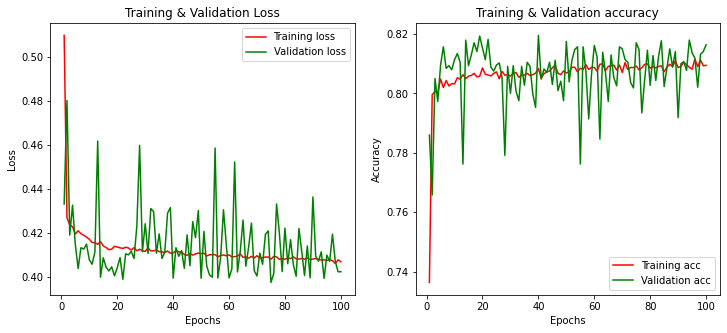

In [ ]:
loss_acc_graph(history_dict8)

In [ ]:
results = model8.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

138/138 [==============================] - 0s 1ms/step - loss: 0.4023 - acc: 0.8163
Test accuracy:  0.8163265585899353


### **LSTM**

**LSTM_model_1**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation, Embedding, LSTM
from keras import optimizers

In [ ]:
X_train, y_train, X_test, y_test = train_test_set(rnn_data)

In [ ]:
def lstm1():
    model = Sequential()
    model.add(LSTM(48, input_shape = (1,13), return_sequences = False, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['acc'])
    
    return model

In [ ]:
ltsm_model1 = lstm1()
history9 = ltsm_model1.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test), verbose = 0)
history_dict9 = history9.history

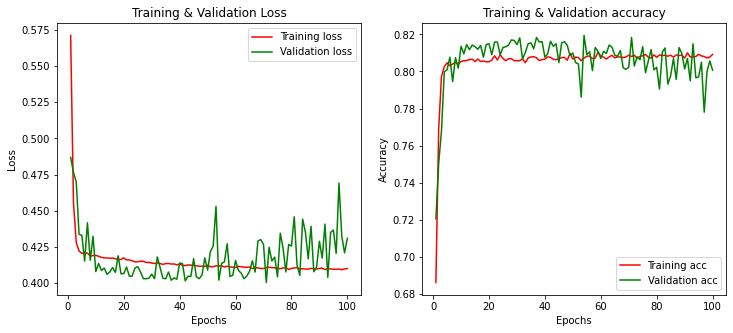

In [ ]:
loss_acc_graph(history_dict9)

In [ ]:
results = ltsm_model1.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

138/138 [==============================] - 0s 1ms/step - loss: 0.4310 - acc: 0.8007
Test accuracy:  0.8006802797317505


**LSTM_model_2**

In [ ]:
X_train, y_train, X_test, y_test = train_test_set(rnn_data)

In [ ]:
def lstm2():
    model = Sequential()
    model.add(LSTM(20, input_shape = (1,13), return_sequences = False, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['acc'])
    
    return model

In [ ]:
ltsm_model2 = lstm2()
history10 = ltsm_model2.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test), verbose = 0)
history_dict10 = history10.history

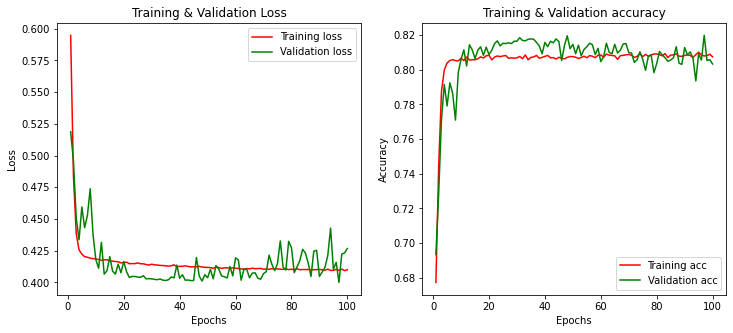

In [ ]:
loss_acc_graph(history_dict10)

In [ ]:
results = ltsm_model2.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

138/138 [==============================] - 0s 1ms/step - loss: 0.4267 - acc: 0.8034
Test accuracy:  0.8034013509750366


**LSTM_model_3**

In [ ]:
X_train, y_train, X_test, y_test = train_test_set(rnn_data)

In [ ]:
def lstm3():
    model = Sequential()
    model.add(LSTM(50, input_shape = (1,13), activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['acc'])
    
    return model

In [ ]:
ltsm_model3 = lstm3()
history11 = ltsm_model3.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test), verbose = 0)
history_dict11 = history11.history

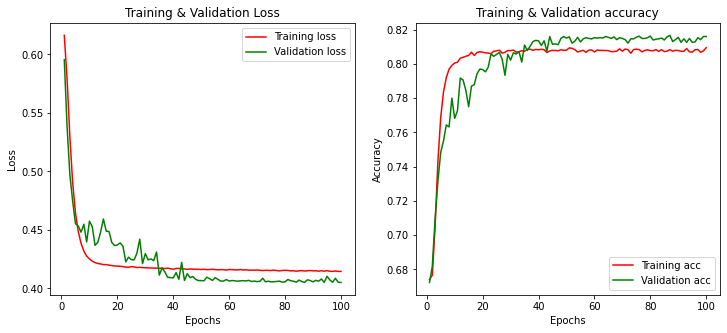

In [ ]:
loss_acc_graph(history_dict11)

In [ ]:
results = ltsm_model3.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

138/138 [==============================] - 0s 1ms/step - loss: 0.4050 - acc: 0.8161
Test accuracy:  0.8160997629165649


**LSTM_model_4**

In [ ]:
X_train, y_train, X_test, y_test = train_test_set(rnn_data)

In [ ]:
def lstm4():
    model = Sequential()
    model.add(LSTM(50, input_shape = (1,13), return_sequences = True, activation='sigmoid'))
    model.add(LSTM(50, return_sequences = False))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['acc'])
    
    return model

In [ ]:
ltsm_model4 = lstm4()
history12 = ltsm_model4.fit(X_train, y_train, epochs = 150, validation_data=(X_test, y_test), verbose = 0)
history_dict12 = history12.history

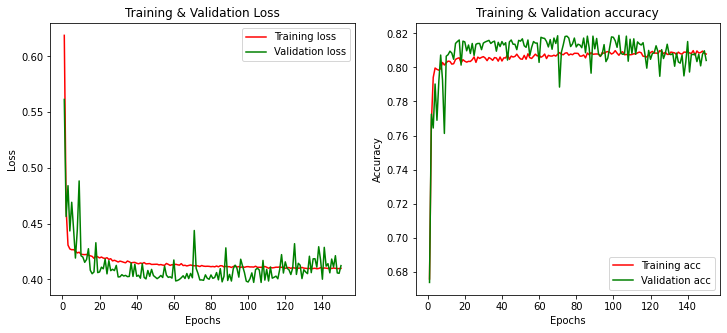

In [ ]:
loss_acc_graph(history_dict12)

In [ ]:
results = ltsm_model4.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

138/138 [==============================] - 0s 2ms/step - loss: 0.4124 - acc: 0.8041
Test accuracy:  0.8040816187858582


**LSTM_model_5**

In [ ]:
X_train, y_train, X_test, y_test = train_test_set(rnn_data)

In [ ]:
def lstm5():
    model = Sequential()
    model.add(LSTM(32, input_shape = (1,13), return_sequences = True, activation='tanh'))
    model.add(LSTM(16, return_sequences = False, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['acc'])
    
    return model

In [ ]:
ltsm_model5 = lstm5()
history13 = ltsm_model5.fit(X_train, y_train, epochs = 150, validation_data=(X_test, y_test), verbose = 0)
history_dict13 = history13.history

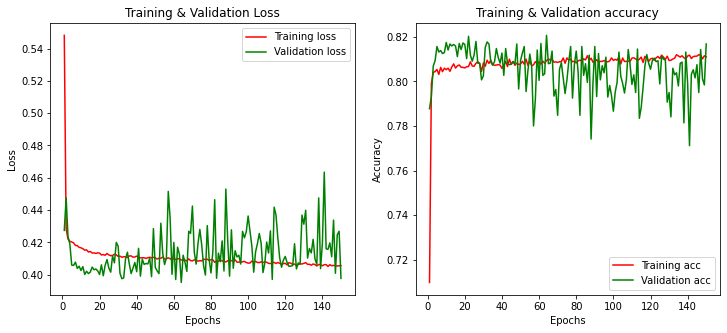

In [ ]:
loss_acc_graph(history_dict13)

In [ ]:
results = ltsm_model5.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

138/138 [==============================] - 0s 2ms/step - loss: 0.3977 - acc: 0.8168
Test accuracy:  0.8167800307273865


**LSTM_model_6**

In [ ]:
X_train, y_train, X_test, y_test = train_test_set(rnn_data)

In [ ]:
def lstm6():
    model = Sequential()
    model.add(LSTM(20, input_shape = (1,13), return_sequences = True))
    model.add(LSTM(20, return_sequences = True))
    model.add(LSTM(20, return_sequences = True))
    model.add(LSTM(20, return_sequences = False))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['acc'])
    
    return model

In [ ]:
ltsm_model6 = lstm6()
history14 = ltsm_model6.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test), verbose = 0)
history_dict14 = history14.history

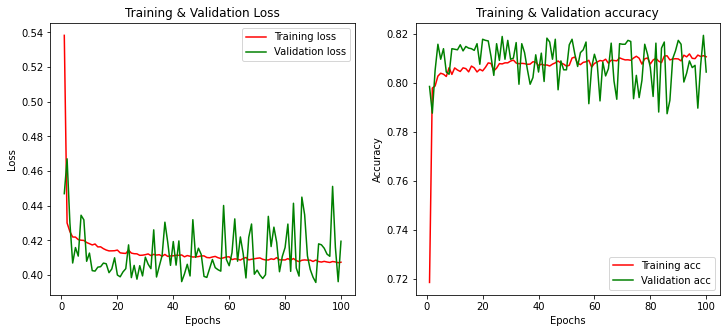

In [ ]:
loss_acc_graph(history_dict14)

In [ ]:
results = ltsm_model6.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

138/138 [==============================] - 0s 2ms/step - loss: 0.4195 - acc: 0.8045
Test accuracy:  0.8045351505279541


**LSTM_model_7**

In [ ]:
X_train, y_train, X_test, y_test = train_test_set(rnn_data)

In [ ]:
def lstm7():
    model = Sequential()
    model.add(LSTM(40, input_shape = (1,13), return_sequences = True, activation='sigmoid'))
    model.add(LSTM(40, return_sequences = True, activation='sigmoid'))
    model.add(LSTM(30, return_sequences = True, activation='sigmoid'))
    model.add(LSTM(20, return_sequences = False, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['acc'])
    
    return model

In [ ]:
ltsm_model7 = lstm7()
history15 = ltsm_model7.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test), verbose = 0)
history_dict15 = history15.history

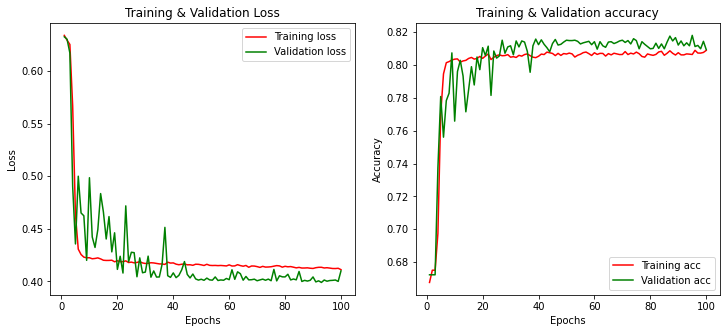

In [ ]:
loss_acc_graph(history_dict15)

In [ ]:
results = ltsm_model7.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

138/138 [==============================] - 0s 2ms/step - loss: 0.4101 - acc: 0.8093
Test accuracy:  0.8092970252037048


### **Bidirectional LSTM**

**양방향 LSTM model_1**

In [ ]:
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation, Embedding, LSTM
from keras import optimizers

In [ ]:
X_train, y_train, X_test, y_test = train_test_set(rnn_data)

In [ ]:
def bidirectional_lstm1():
    model = Sequential()
    model.add(Bidirectional(LSTM(13, return_sequences = False), input_shape = (1,13)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['acc'])
    
    return model

In [ ]:
bidirectional_model1 = bidirectional_lstm1()
history16 = bidirectional_model1.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test), verbose = 0)
history_dict16 = history16.history

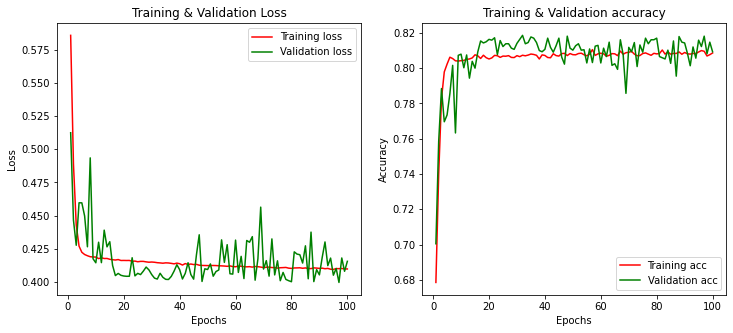

In [ ]:
loss_acc_graph(history_dict16)

In [ ]:
results = bidirectional_model1.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

138/138 [==============================] - 0s 1ms/step - loss: 0.4156 - acc: 0.8093
Test accuracy:  0.8092970252037048


**양방향 LSTM model_2**

In [ ]:
X_train, y_train, X_test, y_test = train_test_set(rnn_data)

In [ ]:
def bidirectional_lstm2():
    model = Sequential()
    model.add(Bidirectional(LSTM(40, return_sequences = False), input_shape = (1,13)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['acc'])
    
    return model

In [ ]:
bidirectional_model2 = bidirectional_lstm2()
history17 = bidirectional_model2.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test), verbose = 0)
history_dict17 = history17.history

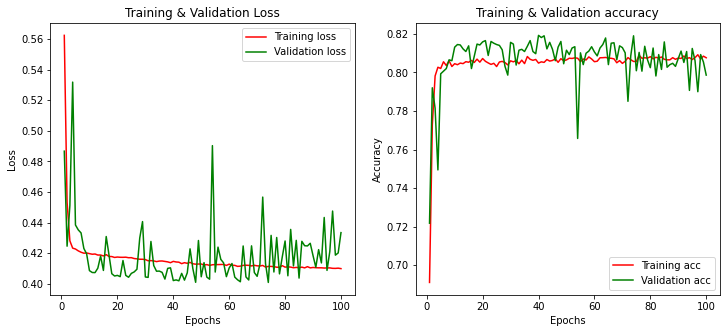

In [ ]:
loss_acc_graph(history_dict17)

In [ ]:
results = bidirectional_model2.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

138/138 [==============================] - 0s 1ms/step - loss: 0.4334 - acc: 0.7986
Test accuracy:  0.7986394762992859


**심층 양방향 LSTM model_3**

In [ ]:
X_train, y_train, X_test, y_test = train_test_set(rnn_data)

In [ ]:
def bidirectional_lstm3():
    model = Sequential()
    model.add(Bidirectional(LSTM(20, return_sequences = True), input_shape = (1,13), activation='sigmoid'))
    model.add(Bidirectional(LSTM(20, return_sequences = False), activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['acc'])
    
    return model

In [ ]:
bidirectional_model3 = bidirectional_lstm3()
history18 = bidirectional_model3.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test), verbose = 0)
history_dict18 = history18.history

In [ ]:
results = bidirectional_model3.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

138/138 [==============================] - 0s 2ms/step - loss: 0.4296 - acc: 0.7912
Test accuracy:  0.7911564707756042


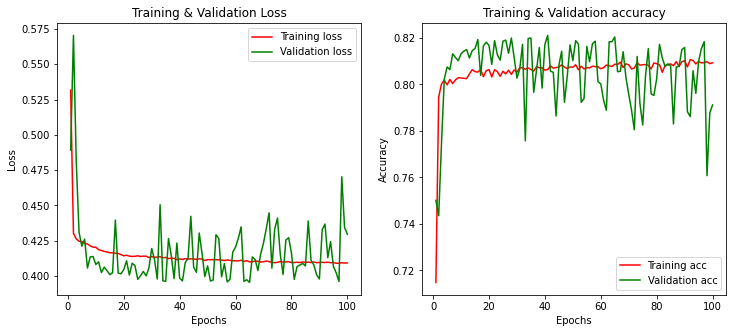

In [ ]:
loss_acc_graph(history_dict18)

**심층 양방향 LSTM model_4**

In [ ]:
X_train, y_train, X_test, y_test = train_test_set(rnn_data)

In [ ]:
def bidirectional_lstm4():
    model = Sequential()
    model.add(Bidirectional(LSTM(40, return_sequences = True), input_shape = (1,13)))
    model.add(Bidirectional(LSTM(40, return_sequences = True)))
    model.add(Bidirectional(LSTM(40, return_sequences = False)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['acc'])
    
    return model

In [ ]:
bidirectional_model4 = bidirectional_lstm4()
history19 = bidirectional_model4.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test), verbose = 0)
history_dict19 = history19.history

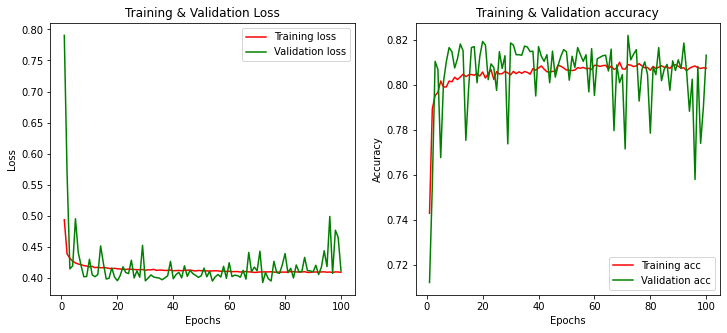

In [ ]:
loss_acc_graph(history_dict19)

In [ ]:
results = bidirectional_model4.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

138/138 [==============================] - 0s 2ms/step - loss: 0.4116 - acc: 0.8132
Test accuracy:  0.8131519556045532


### **GRU**

**GRU model_1**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation, Embedding, LSTM, GRU, Bidirectional, CuDNNGRU,GRU
from keras import optimizers

In [ ]:
X_train, y_train, X_test, y_test = train_test_set(rnn_data)

In [ ]:
def gru1():
    model = Sequential()
    model.add(GRU(50, input_shape = (1,13), return_sequences = True, activation='sigmoid'))
    model.add(GRU(1, return_sequences = False, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['acc'])
    
    return model

In [ ]:
gru_model1 = gru1()
history20 = gru_model1.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test), verbose = 0)
history_dict20 = history20.history

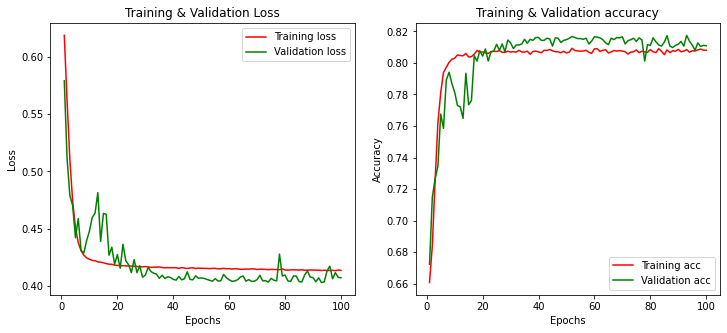

In [ ]:
loss_acc_graph(history_dict20)

In [ ]:
results = gru_model1.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

138/138 [==============================] - 0s 1ms/step - loss: 0.4072 - acc: 0.8109
Test accuracy:  0.8108843564987183


**GRU model_2**

In [ ]:
X_train, y_train, X_test, y_test = train_test_set(rnn_data)

In [ ]:
def gru2():
    model = Sequential()
    model.add(GRU(50, input_shape = (1,13)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['acc'])
    
    return model

In [ ]:
gru_model2 = gru2()
history21 = gru_model2.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test), verbose = 0)
history_dict21 = history21.history

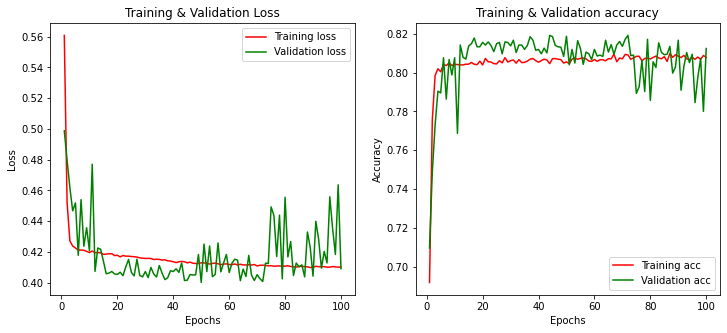

In [ ]:
loss_acc_graph(history_dict21)

In [ ]:
results = gru_model2.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

138/138 [==============================] - 0s 1ms/step - loss: 0.4091 - acc: 0.8125
Test accuracy:  0.8124716281890869


**GRU model_3**

In [ ]:
X_train, y_train, X_test, y_test = train_test_set(rnn_data)

In [ ]:
def gru3():
    model = Sequential()
    model.add(GRU(50, input_shape = (1,13), return_sequences = True))
    model.add(GRU(50, return_sequences = True))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['acc'])
    
    return model

In [ ]:
gru_model3 = gru3()
history22 = gru_model3.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test), verbose = 0)
history_dict22 = history22.history

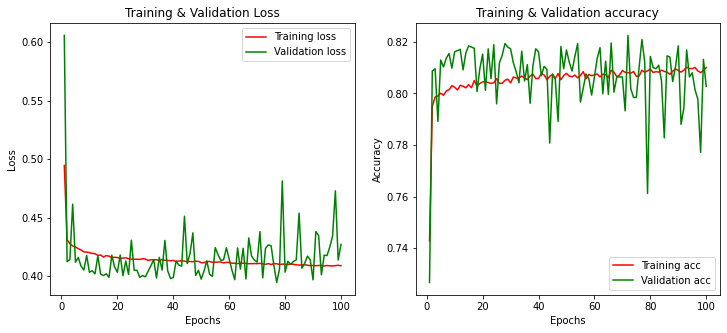

In [ ]:
loss_acc_graph(history_dict22)

In [ ]:
results = gru_model3.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

138/138 [==============================] - 0s 2ms/step - loss: 0.4270 - acc: 0.8027
Test accuracy:  0.8027210831642151


**GRU model_4**

In [ ]:
X_train, y_train, X_test, y_test = train_test_set(rnn_data)

In [ ]:
def gru4():
    model = Sequential()
    model.add(GRU(50, input_shape = (1,13), return_sequences = True, activation='sigmoid'))
    model.add(GRU(50, return_sequences = True, activation='sigmoid'))
    model.add(GRU(1, return_sequences = False, activation='sigmoid'))
    
    model.compile(loss = 'mean_squared_error', optimizer = 'rmsprop', metrics = ['acc'])
    
    return model

In [ ]:
gru_model4 = gru4()
history23 = gru_model4.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test), verbose = 0)
history_dict23 = history23.history

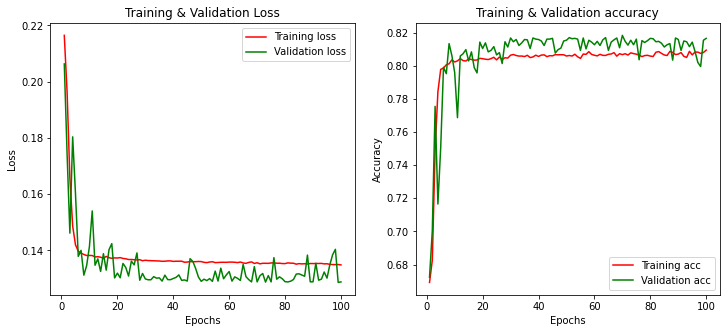

In [ ]:
loss_acc_graph(history_dict23)

In [ ]:
results = gru_model4.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

138/138 [==============================] - 0s 2ms/step - loss: 0.1288 - acc: 0.8166
Test accuracy:  0.8165532946586609


**GRU model_5**

In [ ]:
X_train, y_train, X_test, y_test = train_test_set(rnn_data)

In [ ]:
def gru5():
    model = Sequential()
    model.add(GRU(50, input_shape = (1,13), return_sequences = True))
    model.add(GRU(50, return_sequences = True))
    model.add(GRU(13, return_sequences = True))
    model.add(GRU(13, return_sequences = True))
    model.add(GRU(1, return_sequences = False, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['acc'])
    
    return model

In [ ]:
gru_model5 = gru5()
history24 = gru_model5.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test), verbose = 0)
history_dict24 = history24.history

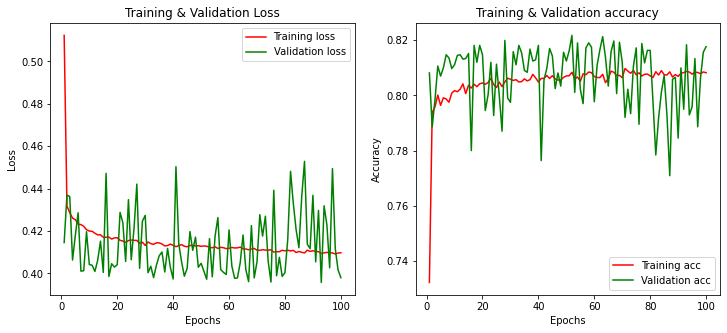

In [ ]:
loss_acc_graph(history_dict24)

In [ ]:
results = gru_model5.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

138/138 [==============================] - 0s 2ms/step - loss: 0.3980 - acc: 0.8177
Test accuracy:  0.8176870942115784


**GRU model_6**

In [ ]:
X_train, y_train, X_test, y_test = train_test_set(rnn_data)

In [ ]:
def gru6():
    model = Sequential()
    model.add(Bidirectional(GRU(50, input_shape = (1,13), return_sequences = True)))
    model.add(Bidirectional(GRU(50, return_sequences = True)))
    model.add(GRU(1, return_sequences = False, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['acc'])
    
    return model

In [ ]:
gru_model6 = gru6()
history25 = gru_model6.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test), verbose = 0)
history_dict25 = history25.history

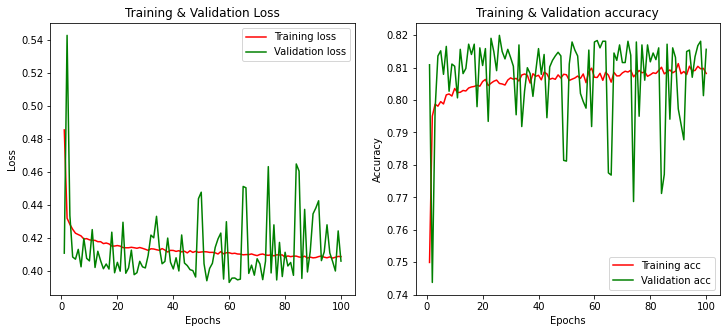

In [ ]:
loss_acc_graph(history_dict25)

In [ ]:
results = gru_model6.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

138/138 [==============================] - 0s 2ms/step - loss: 0.4057 - acc: 0.8156
Test accuracy:  0.815646231174469
